In [3]:
! conda install rasterio


/home/vedaya/miniconda3/lib/python3.12/site-packages/conda/base/context.py:198: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
/home/vedaya/miniconda3/lib/python3.12/site-packages/conda/base/context.py:198: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configur

In [2]:
import rasterio


In [5]:
new = rasterio.open('LC09_L2SP_147048_20231202_20231203_02_T1_SR_B2.TIF')

In [7]:
import rasterio


# Assuming your file is in the data folder
try:
    # Method 1: Direct path
    with rasterio.open('LC09_L2SP_147048_20231202_20231203_02_T1_SR_B2.TIF') as dataset:
        # Read the data
        data = dataset.read()
        print("Successfully opened the file!")
        print(f"Dataset shape: {data.shape}")
except Exception as e:
    print(f"Error: {e}")

Successfully opened the file!
Dataset shape: (1, 7791, 7631)


In [8]:
dataset.bounds

BoundingBox(left=235185.0, bottom=1800885.0, right=464115.0, top=2034615.0)

In [10]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Let's read a single band file
file_path = 'LC09_L2SP_147048_20231202_20231203_02_T1_SR_B2.TIF'  # This is the red band

with rasterio.open(file_path) as dataset:
    # Read the band data
    band_data = dataset.read(1)  # The '1' means read the first (and only) band
    
    # Get basic information
    print(f"Image shape: {band_data.shape}")
    print(f"Data type: {band_data.dtype}")
    print(f"Spatial resolution: {dataset.transform[0]} meters")

Image shape: (7791, 7631)
Data type: uint16
Spatial resolution: 30.0 meters


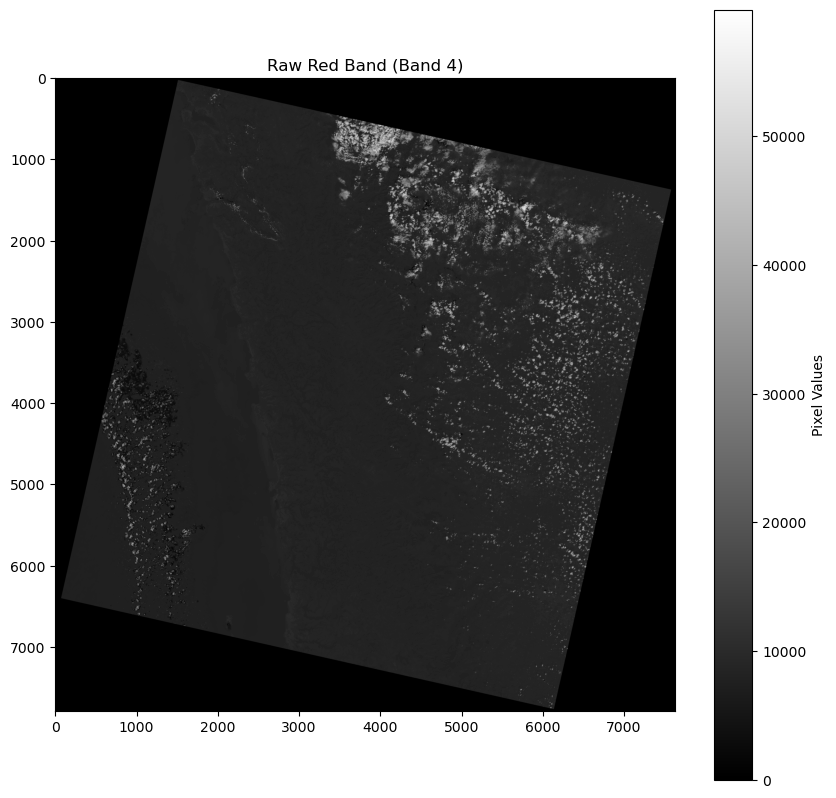

In [11]:
# Basic visualization of the band
plt.figure(figsize=(10, 10))
plt.imshow(band_data, cmap='gray')
plt.colorbar(label='Pixel Values')
plt.title('Raw Red Band (Band 4)')

plt.show()

In [12]:
# Print important metadata
print("\nImage Metadata:")
print("-" * 50)
for key in dataset.meta.keys():
    print(f"{key}: {dataset.meta[key]}")


Image Metadata:
--------------------------------------------------
driver: GTiff
dtype: uint16
nodata: 0.0
width: 7631
height: 7791
count: 1
crs: EPSG:32643
transform: | 30.00, 0.00, 235185.00|
| 0.00,-30.00, 2034615.00|
| 0.00, 0.00, 1.00|


Min value: 0
Max value: 61552
Mean value: 6833.085222002054


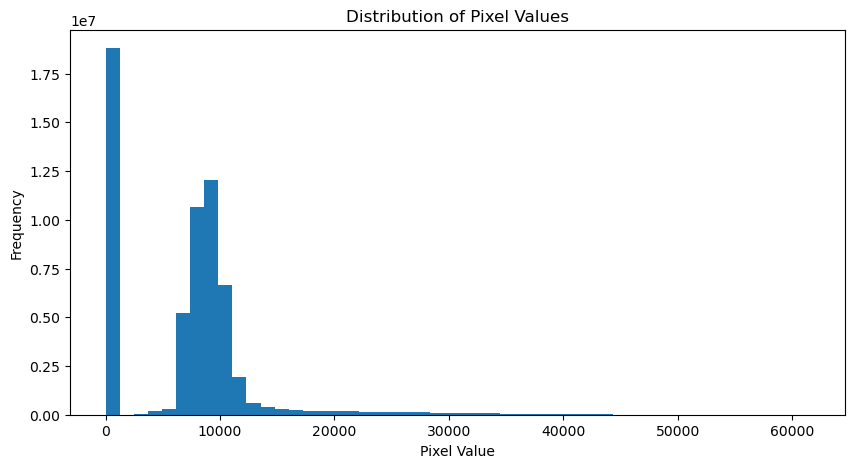

In [13]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Read our band again
file_path = 'LC09_L2SP_147048_20231202_20231203_02_T1_SR_B4.TIF'
with rasterio.open(file_path) as dataset:
    band_data = dataset.read(1)

# Let's look at the data distribution first
print(f"Min value: {np.min(band_data)}")
print(f"Max value: {np.max(band_data)}")
print(f"Mean value: {np.mean(band_data)}")

# Create histogram of pixel values
plt.figure(figsize=(10, 5))
plt.hist(band_data.flatten(), bins=50)
plt.title('Distribution of Pixel Values')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

Original Data Statistics:
Min value: 0
Max value: 61552
Mean value: 6833.085222002054


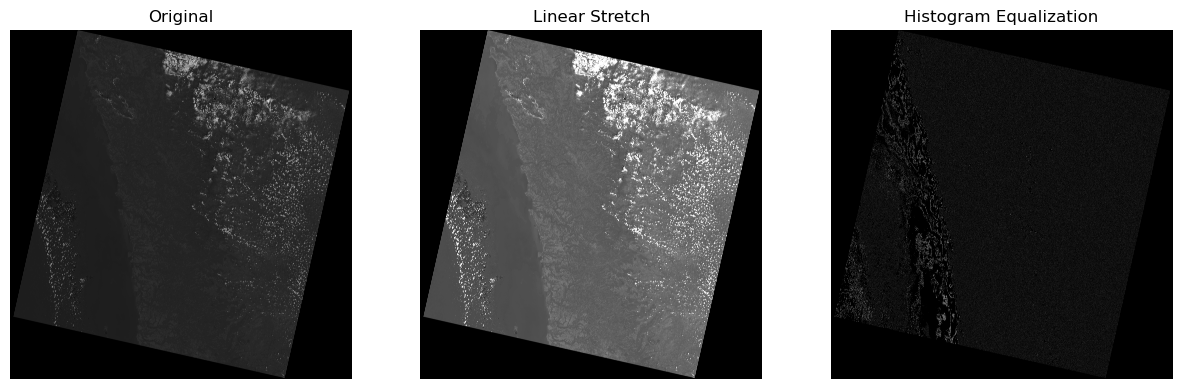

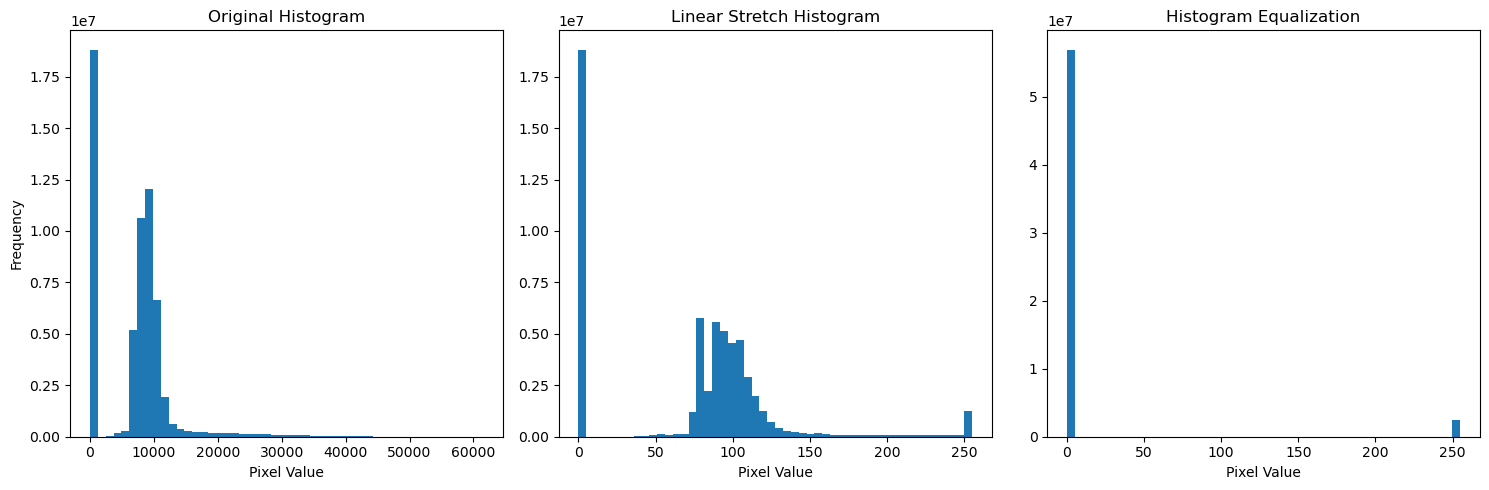

In [16]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# First, let's read the data
file_path = 'LC09_L2SP_147048_20231202_20231203_02_T1_SR_B4.TIF'
with rasterio.open(file_path) as dataset:
    band_data = dataset.read(1)

# Let's check our data ranges first
print("Original Data Statistics:")
print(f"Min value: {np.min(band_data)}")
print(f"Max value: {np.max(band_data)}")
print(f"Mean value: {np.mean(band_data)}")

# 1. Linear Stretch (Contrast Stretch)
def linear_stretch(band):
    """
    Apply linear stretch to the image
    Why? To enhance contrast by using the full range of possible values
    """
    # Remove outliers using percentiles
    p2, p98 = np.percentile(band, (2, 98))
    stretched = np.clip((band - p2) * 255.0 / (p98 - p2), 0, 255)
    return stretched.astype(np.uint8)

# 2. Histogram Equalization (Fixed version)
def histogram_equalization(band):
    """
    Apply histogram equalization
    Why? To improve contrast by better distributing the intensity values
    """
    # First normalize the band to 0-255 range
    band_normalized = ((band - band.min()) * 255 / (band.max() - band.min())).astype(np.uint8)
    
    # Calculate histogram
    hist, bins = np.histogram(band_normalized.flatten(), 256, [0, 256])
    
    # Calculate cumulative distribution
    cdf = hist.cumsum()
    
    # Normalize the cdf
    cdf_normalized = cdf * float(hist.max()) / cdf.max()
    
    # Create lookup table
    cdf_m = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
    cdf_final = np.ma.filled(cdf_m, 0).astype('uint8')
    
    # Apply the transformation
    return cdf_final[band_normalized]

# Apply both enhancements
linear_enhanced = linear_stretch(band_data)
hist_enhanced = histogram_equalization(band_data)

# Create figure to display results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original image
ax1.imshow(band_data, cmap='gray')
ax1.set_title('Original')
ax1.axis('off')

# Linear stretch
ax2.imshow(linear_enhanced, cmap='gray')
ax2.set_title('Linear Stretch')
ax2.axis('off')

# Histogram equalization
ax3.imshow(hist_enhanced, cmap='gray')
ax3.set_title('Histogram Equalization')
ax3.axis('off')

plt.show()

# Let's also look at the histograms to understand what happened
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Original histogram
ax1.hist(band_data.flatten(), bins=50)
ax1.set_title('Original Histogram')
ax1.set_xlabel('Pixel Value')
ax1.set_ylabel('Frequency')

# Linear stretch histogram
ax2.hist(linear_enhanced.flatten(), bins=50)
ax2.set_title('Linear Stretch Histogram')
ax2.set_xlabel('Pixel Value')

# Histogram equalization result
ax3.hist(hist_enhanced.flatten(), bins=50)
ax3.set_title('Histogram Equalization')
ax3.set_xlabel('Pixel Value')

plt.tight_layout()
plt.show()

In [21]:
with rasterio.open('LC09_L2SP_147048_20231202_20231203_02_T1_SR_B4.TIF') as src:  # Red
    red_band = src.read(1)
with rasterio.open('LC09_L2SP_147048_20231202_20231203_02_T1_SR_B3.TIF') as src:  # Green
    green_band = src.read(1)
with rasterio.open('LC09_L2SP_147048_20231202_20231203_02_T1_SR_B2.TIF') as src:  # Blue
    blue_band = src.read(1)
with rasterio.open('LC09_L2SP_147048_20231202_20231203_02_T1_SR_B5.TIF') as src:  # NIR
    nir_band = src.read(1)

In [28]:
def create_composite(r,g,b):
    rgb = np.dstack((
        linear_stretch(r),
        linear_stretch(g),
        linear_stretch(b)
    ))
natural_color = create_composite(red_band, green_band, blue_band)  
false_color = create_composite(nir_band, red_band, green_band)    
agriculture = create_composite(nir_band, red_band, blue_band)

TypeError: Image data of dtype object cannot be converted to float

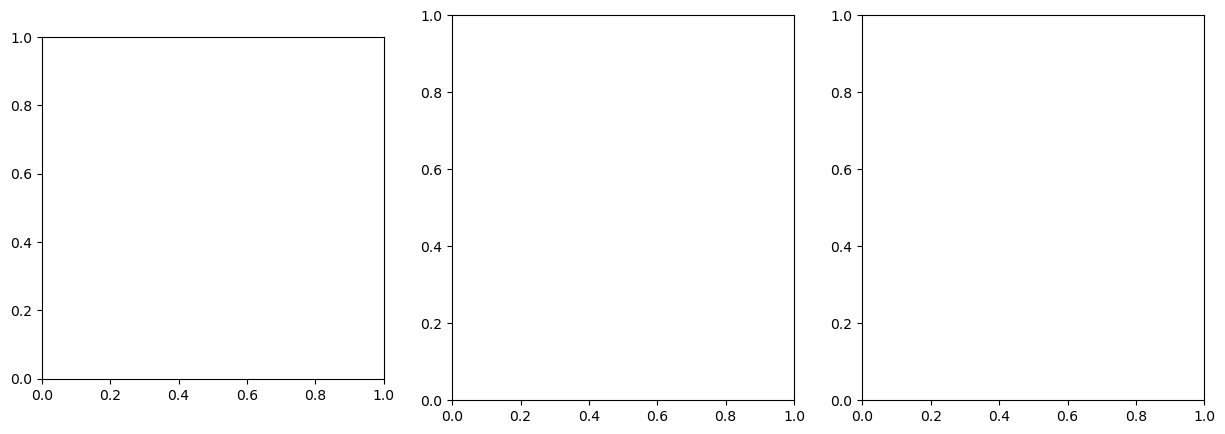

In [29]:
fig, (ax1, ax2, ax3) =plt.subplots(1,3,figsize=(15,5))
ax1.imshow(natural_color)
ax2.imshow(flase_color)
ax3.imshow(agriculture)
plt.show()

Creating composites...
Natural color shape: (7791, 7631, 3)
False color shape: (7791, 7631, 3)
Agriculture composite shape: (7791, 7631, 3)


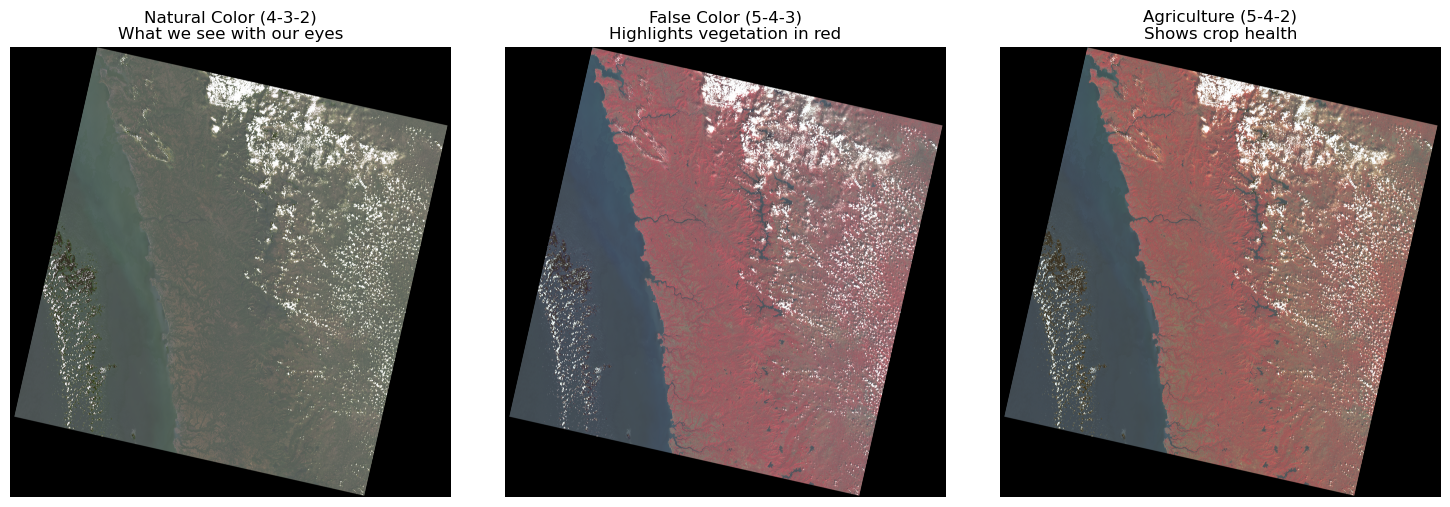


What each composite shows:

Natural Color (4-3-2):
- Shows Earth as we naturally see it
- Vegetation appears green
- Water appears blue
- Urban areas appear gray/white

False Color (5-4-3):
- Healthy vegetation appears bright red
- Urban areas appear blue/gray
- Water appears dark blue/black
- Bare soil appears brown

Agriculture (5-4-2):
- Healthy vegetation appears bright green
- Urban areas appear white
- Water appears dark
- Stressed vegetation appears brown

Pixel value ranges:

Natural Color:
Min value: 0
Max value: 255
Mean value: 71.9246394482806

False Color:
Min value: 0
Max value: 255
Mean value: 79.20589935051517

Agriculture:
Min value: 0
Max value: 255
Mean value: 77.13780794900013


In [30]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open('LC09_L2SP_147048_20231202_20231203_02_T1_SR_B4.TIF') as src:  # Red
    red_band = src.read(1)
with rasterio.open('LC09_L2SP_147048_20231202_20231203_02_T1_SR_B3.TIF') as src:  # Green
    green_band = src.read(1)
with rasterio.open('LC09_L2SP_147048_20231202_20231203_02_T1_SR_B2.TIF') as src:  # Blue
    blue_band = src.read(1)
with rasterio.open('LC09_L2SP_147048_20231202_20231203_02_T1_SR_B5.TIF') as src:  # NIR
    nir_band = src.read(1)

# 2. Create a function for linear stretch
# Why? To enhance the contrast of each band before combining
def linear_stretch(band):
    p2, p98 = np.percentile(band, (2, 98))
    stretched = np.clip((band - p2) * 255.0 / (p98 - p2), 0, 255)
    return stretched.astype(np.uint8)

# 3. Function to create color composite
# Why? To properly stack and process bands for visualization
def create_composite(r, g, b):
    # First stretch each band
    r_stretched = linear_stretch(r)
    g_stretched = linear_stretch(g)
    b_stretched = linear_stretch(b)
    
    # Stack bands
    # Why numpy.dstack? It stacks arrays in sequence depth-wise (along third axis)
    rgb = np.dstack((r_stretched, g_stretched, b_stretched))
    return rgb

# 4. Create different composites
print("Creating composites...")
# Natural color (True color)
natural_color = create_composite(red_band, green_band, blue_band)
print("Natural color shape:", natural_color.shape)

# False color (NIR composite)
false_color = create_composite(nir_band, red_band, green_band)
print("False color shape:", false_color.shape)

# Agriculture composite
agriculture = create_composite(nir_band, red_band, blue_band)
print("Agriculture composite shape:", agriculture.shape)

# 5. Display the composites
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Natural color
ax1.imshow(natural_color)
ax1.set_title('Natural Color (4-3-2)\nWhat we see with our eyes')
ax1.axis('off')

# False color
ax2.imshow(false_color)
ax2.set_title('False Color (5-4-3)\nHighlights vegetation in red')
ax2.axis('off')

# Agriculture
ax3.imshow(agriculture)
ax3.set_title('Agriculture (5-4-2)\nShows crop health')
ax3.axis('off')

plt.tight_layout()
plt.show()

# 6. Let's analyze what we're seeing
print("\nWhat each composite shows:")
print("\nNatural Color (4-3-2):")
print("- Shows Earth as we naturally see it")
print("- Vegetation appears green")
print("- Water appears blue")
print("- Urban areas appear gray/white")

print("\nFalse Color (5-4-3):")
print("- Healthy vegetation appears bright red")
print("- Urban areas appear blue/gray")
print("- Water appears dark blue/black")
print("- Bare soil appears brown")

print("\nAgriculture (5-4-2):")
print("- Healthy vegetation appears bright green")
print("- Urban areas appear white")
print("- Water appears dark")
print("- Stressed vegetation appears brown")

# 7. Optional: Let's look at the pixel values in each composite
print("\nPixel value ranges:")
for name, composite in [("Natural Color", natural_color), 
                       ("False Color", false_color), 
                       ("Agriculture", agriculture)]:
    print(f"\n{name}:")
    print(f"Min value: {np.min(composite)}")
    print(f"Max value: {np.max(composite)}")
    print(f"Mean value: {np.mean(composite)}")